# Домашняя работа 3. Задача классификации

~~*Дедлайн мягкий как облачко: 1 ноября, 21:00*~~

~~*Дедлайн жесткий как неспелая хурма: 5 ноября, 21:00*~~

*Дедлайн унылый как Асино настроение: 6 ноября, 21:00* (жесткий и единственный, без снятия баллов)

### Оценивание и штрафы

Максимальная оценка — 10 баллов. Еще есть 2 бонусных балла, которые можно добавить к любым домашкам или проверочным.

Не списывайте, иначе всем участникам обнулим :)

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

**Оценка: ...**

In [79]:
print('Всем удачи!👒')

Всем удачи!👒


In [80]:
from __future__ import annotations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

## Часть 1. Логрег своими руками (4.5 балла)

**Задание 1 (4 балла)**. Реализуйте логистическую регрессию, обучаемую с помощью:
- градиентного спуска **(2 балла)**

- стохастического градиентного спуска **(2 балла)**

Во всех пунктах необходимо соблюдать два условия:
- Циклы можно использовать только для итераций градиентного спуска;
- В качестве критерия останова необходимо использовать (одновременно):

    - проверку на евклидову норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка $10^{-6}$), задаваемого параметром `tolerance`;
    - достижение максимального числа итераций (например, 10000), задаваемого параметром `max_iter`.

Чтобы проследить, что оптимизационный процесс действительно сходится, добавим атрибут класса `loss_history`. В нём после вызова метода `fit` должны содержаться значения функции потерь для всех итераций градиентного спуска, начиная с нулевой.

Инициализировать веса можно случайным образом или нулевым вектором.

In [81]:
from sklearn.base import BaseEstimator

class LogReg(BaseEstimator):
    def __init__(self, gd_type: str = 'stochastic', tolerance: float = 1e-4, 
                 max_iter: int = 1000, eta: float = 1e-2,
                 w0: np.array = None) -> None:
        """
        Args:
          gd_type: Type of gradient descent ('full' or 'stochastic'). 
          
          tolerance: Threshold for stopping gradient descent.
          
          max_iter: Maximum number of steps in gradient descent.
          
          eta: Learning rate.
          
          w0: Array of shape d (d — number of weights to optimize).
              Initial weights.
        """
        self.gd_type = gd_type         #это тип (полный или стохастический) 
        self.tolerance = tolerance     #это проверка на евклидову норму разности весов на двух сосед итер  
        self.max_iter = max_iter      # это максим кол-во итераций град спуска 
        self.eta = eta                # скорость обучения 
        self.w0 = w0                   #массив весов 
        self.w = None                  #массив предсказанных классов 
        self.loss_history = None        #значения функции потерь для всех итераций градиентного спуска, начиная с нулевой

    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    
    def fit(self, X: np.array, y: np.array) -> LogReg:
        """Fit the model on training data. Also, save value of loss after each iteration.
        Args:
          X: Training data.
          y: Target.
        Returns: 
          self: Fitted classsifier.  
        """
        self.loss_history = []
        self.w0 = np.zeros(X.shape[1])
        self.w=np.zeros(len(y))
        
        
        W=np.empty([self.max_iter,len(self.w0)])
        
        for i in range(self.max_iter):
            
            gradient = self.calc_gradient(X,y)
            self.w0 -= self.eta * gradient
            W[i]=self.w0
            if i>0 and np.linalg.norm(W[i]-W[i-1])<self.tolerance:
                break
            e = self.calc_loss(X, y)
            self.loss_history.append(e) #сохраняем историю
        return self
    
    def predict_proba(self, X: np.array) -> np.array:
        """Calculate probability of positive and negative class for each observation.
        
        Args:
          X: Array of shape (n, d).
             Data.
        
        Returns: 
             Array of shape (n, 2).
             Predicted probabilities.
        """
        
        if self.w is None:
            raise Exception('Not trained yet')
    
        return self.sigmoid(np.dot(X, self.w0)) 
           
    
    def predict(self, X: np.array) -> np.array:
        """Predict class for each observation.
        
        Args:
          X: Array of shape (n, d).
             Data.
        
        Returns: 
             Array of shape (n,).
             Predicted class labels.  
             
        """
        self.w=self.predict_proba(X).round()
        if self.w is None:
            raise Exception('Not trained yet')
    
        return self.w
        
    
    def calc_gradient(self, X: np.array, y: np.array) -> np.array:
        """Calculate gradient of loss function after each iteration.
        
        Args:
          X: Array of shape (n, d), n can be equal to 1 if 'stochastic'.
          y: Array of shape (n,).
        
        Returns:
          Array of shape (d,).
          Gradient of loss function after current iteration.
        """
        if self.gd_type =='full':
            z = np.dot(X, self.w0)
            h = self.sigmoid(z)
            res=np.dot(X.T, (h - y)) / y.size
            
        if self.gd_type == 'stochastic':
            i = np.random.randint(0, len(y))
            Xi = X[i]
            yi = y[i]
            z = np.dot(Xi, self.w0)
            h = self.sigmoid(z)
            res=(Xi.T.dot((h - yi)))
            pass
        
        if self.gd_type not in ['stochastic','full']:
            raise Exception('Not correct type gradient decision')
            
        return res

    def calc_loss(self, X: np.array, y: np.array) -> float:
        """Calculate value of loss function after each iteration.
        
        Args:
          X: Array of shape (n, d).
          y: Array of shape (n,).
        
        Returns:
          Value of loss function after current iteration.
        """ 
        z = np.dot(X, self.w0)
        h = self.sigmoid(z)
        return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()

Далее предполагается, что вы используете собственную реализацию логистической регрессии.
Если с написанием класса возникли проблемы, используйте реализацию sklearn, чтобы не терять баллы за остальные задания.

В части 2 и далее я бы всем советовала использовать реализацию sklearn.

Сгенерируем синтетические данные.

In [82]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

**Задание 2 (0.5 балла).** Обучите логистическую регрессию на синтетических данных. Нарисуйте изменение лосса во время обучения.

In [83]:
clf = LogReg(gd_type= 'full') 
clf.fit(X_train,y_train)
clf.predict(X_test[:2, :])
clf.predict_proba(X_test[:2, :])

array([0.59071706, 0.01289232])

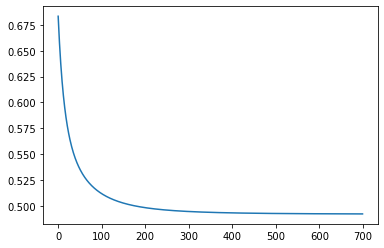

In [84]:
import matplotlib.pyplot as plt

it=[i for i in range(0,len(clf.loss_history))]
plt.plot(it, clf.loss_history)

На тестовой части посчитайте ROC-AUC, PR-AUC. Постройте ROC и PR кривые.

In [85]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, clf.predict_proba(X_test))

0.8453512473379914

In [86]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import fbeta_score, make_scorer

y_scores = clf.predict_proba(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

In [87]:
def pr_auc_score(y_true, y_score):
    """
    Generates the Area Under the Curve for precision and recall.
    """
    precision, recall, thresholds = \
        precision_recall_curve(y_true, y_score[:, 1])
    return auc(recall, precision, reorder=True)

pr_auc_scorer = make_scorer(pr_auc_score, greater_is_better=True,
                            needs_proba=True)
pr_auc_scorer

make_scorer(pr_auc_score, needs_proba=True)

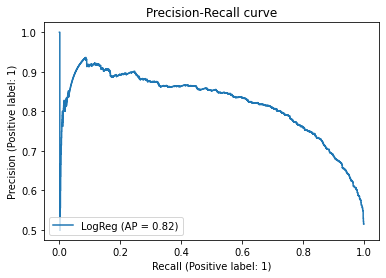

In [88]:
from sklearn.metrics import PrecisionRecallDisplay
y_score = clf.predict_proba(X_test)

display = PrecisionRecallDisplay.from_predictions(y_test, y_score, name="LogReg")
_ = display.ax_.set_title("Precision-Recall curve")


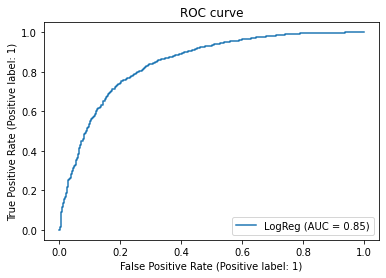

In [89]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

y_score = clf.predict_proba(X_test)
display= RocCurveDisplay.from_predictions(y_test, y_score,name="LogReg")
_ = display.ax_.set_title("ROC curve")

## Часть 2. Работа с категориальными признаками (2.5 балла)

В этой части мы научимся обрабатывать категориальные переменные. Как вы уже знаете, закодировать их в виде столбика чисел недостаточно (это задаёт некоторый порядок, которого на категориальных переменных может и не быть, но модель попробует его выучить). Существует два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

__Подготовка данных.__

Загрузим данные [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о маркетинговой кампании какого-то банка, объектом в нем является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит), целевой переменной — ответ клиента (согласился ли он открыть депозит?). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы — более подробная информация на страничке с датасетом.

In [90]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


__Задание 3 (0.5 балла).__ Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, укажите значение параметра `stratify`. Один из столбцов (помимо таргета :) ) стоит сразу выкинуть из обучающей выборки. Какой? Не отказывайте себе. 



In [91]:
df['y'] = df['y'].replace({'no': 0, 'yes': 1})
y = (df.y == 1)

In [92]:
y.value_counts()

False    36548
True      4640
Name: y, dtype: int64

`Обратим внимание на разбалансированность таргета`

**Ответ:** Выкидываем Duration. Из описания датасета ясно, что при нулевом Duration таргет будет нулевым.

In [93]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=777, stratify=y)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c `AUC-PR`) при применении логистической регрессии. Здесь и далее для реализации последовательности этих действий (обработка признаков + обучение модели) используйте пайплайны. Замерьте время, потребовавшееся на обучение модели (с учетом кодирования признаков).

__Вопрос__: почему в данном задании мы выбрали метрикой именно `AUC-PR`, а не, к примеру, `AUC-ROC`?

__Ваш ответ__: Датасет разбалансированный, ROC-AUC в данном случае не будет устойчив к дисбалансу классов.  
               Для корректной оценки классификатора на unbalanced данных точность (precision) и полнота (recall) дают корректную                оценку (пример ниже)

In [94]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import average_precision_score
from sklearn.metrics import PrecisionRecallDisplay, precision_score, recall_score
from sklearn.metrics import classification_report as cls_report
from sklearn.metrics import RocCurveDisplay, roc_auc_score
from sklearn.linear_model import LogisticRegression

In [95]:
categorical_features = [cat for cat in X.columns if X[cat].dtype == 'object']
numeric_features = [doggo for doggo in X.columns if X[doggo].dtype != 'object']

In [96]:
def get_pr(y_true, y_pred):
    print(f'Precision score: {precision_score(y_true, y_pred)} \nRecall score: {recall_score(y_true, y_pred)}')

In [97]:
#%%timeit
col = ColumnTransformer(transformers = [('ord', OrdinalEncoder(), categorical_features),('same', 'passthrough',numeric_features)])
enc_logit = Pipeline([('OrdinalEncoder', col), ('logit', LogisticRegression(solver='liblinear'))])

enc_logit.fit(X_train, y_train)
y_pred = enc_logit.predict(X_test)
get_pr(y_test, y_pred)

Precision score: 0.6763157894736842 
Recall score: 0.22155172413793103


__Задание 4 (0.5 балла).__ Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели. Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.



In [98]:
#%%timeit
col = ColumnTransformer(transformers = [('one_hot', OneHotEncoder(), categorical_features),('same', 'passthrough',numeric_features)])
enc_logit = Pipeline([('One_hot', col), ('logit', LogisticRegression(solver='liblinear'))])

enc_logit.fit(X_train, y_train)
y_pred = enc_logit.predict(X_test)
get_pr(y_test, y_pred)

Precision score: 0.6945945945945946 
Recall score: 0.22155172413793103


Качество модели после One-Hot-Encoding почти не изменилось: на 0.0035 увеличилась точность оценки, на 0.002 упала полнота

Как можно было заменить, one-hot-кодирование может сильно увеличивать количество признаков в датасете, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирования категориальных признаков — счётчики. Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

__Задание 5 (0.5 балла).__ Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве. Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков). Заметили ли вы что-то интересное?

Простой кодировщик, на линейной комбинации  
Если столбцы явно не указаны, каунтить будет по всем  
Не наследуется, в пайплайне работать не будет  

In [99]:
def counterizer(data, target: str, columns):
    try:
        columns.remove(target)
    except:
        pass

    for column in columns:
        uniques = list(data[column].unique())
        for unique_values in uniques:
            target_mean = data[data[column] == unique_values][target].mean()
            data[column].replace({unique_values: target_mean}, inplace=True)
    return data

In [100]:
# %%timeit
data_c = df.copy()
data_c = counterizer(data_c, target = 'y', columns = categorical_features)
data_train, data_test = train_test_split(data_c.drop(['duration', 'y'], axis=1), train_size=0.75, random_state=777, stratify=y)

counted = logreg_ = Pipeline(steps=[('logreg', LogisticRegression(solver='liblinear'))]).fit(data_train, y_train)
y_pred = counted.predict(data_test)
get_pr(y_test, y_pred)

Precision score: 0.7112462006079028 
Recall score: 0.20172413793103447


При использовании счетчиков точность незначительно увеличилась, однако заметно упала полнота

Отметим, что такие признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем «утечку» целевой переменной в признаки. Это ведёт к переобучению, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении счетчика для конкретного объекта его целевая метка не использовалась. Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Вносить шум в посчитанные признаки. 

__Задание 6 (0.5 балла).__ Реализуйте корректное вычисление счётчиков самым простым способом — добавлением шума к значениям (постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков). Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.
Какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием можно отметить?

In [101]:
%%time
dc = data_c.copy()
noise = np.random.normal(np.random.random(1), np.random.random(1), (df.shape[0], len(categorical_features)))
print(dc['education'].mean())
dc[categorical_features] += noise
print(dc['education'].mean())
data_train, data_test = train_test_split(dc.drop(['duration', 'y'], axis=1), train_size=0.75, random_state=777, stratify=y)

model = LogisticRegression(solver='liblinear').fit(data_train, y_train)
y_pred = model.predict(data_test)
get_pr(y_test, y_pred)

0.11265417111774455
0.29780710860712156
Precision score: 0.7112462006079028 
Recall score: 0.20172413793103447
Wall time: 210 ms


После добавления шума точность и полнота не изменились. По сравнению с one-hot мы можем немного выйграть в точности, но также немного потерять в полноте

__Задание 7 (0.5 балла).__ В данных имеется признак «возраст клиента». Сейчас мы интерпретируем его как числовой, что в общем случае для линейной модели может быть неверной гипотезой. Тем не менее, у этого признака есть довольно много уникальных значений (сколько?), поэтому применять к нему one-hot кодирование может оказаться излишним. Попробуйте закодировать возраст с помощью счетчиков. Стало ли лучше?



In [102]:
transf = ColumnTransformer(transformers = [('One_Hot', OneHotEncoder(), categorical_features),
                                           ('same', 'passthrough', numeric_features[1:])])

data = df.copy(deep=True)
data = counterizer(data, target='y', columns=['age'])

train, test = train_test_split(data.drop(['duration', 'y'], axis = 1), train_size=0.75, random_state=777, stratify=y)

estimator = Pipeline(steps = [('transf', transf), ('logreg', LogisticRegression(solver='liblinear'))]).fit(train, y_train)
get_pr(y_test, estimator.predict(test))

Precision score: 0.6723716381418093 
Recall score: 0.23706896551724138


После применения к возрасту счетчиков немного повысилась полнота, но точность упала

Можно пойти и в обратную сторону. У нас есть признаки «месяц и день недели» для звонка. Попробуйте интерпретировать их как числовые (месяц от 0 до 12, дни недели от 0 до 4). Стало ли лучше в этот раз?

In [103]:
no_cats = [*set(categorical_features)-set(['month', 'day_of_week'])]

estim = [OrdinalEncoder(), OneHotEncoder()]
for i in range(0,2):
    trans = ColumnTransformer(transformers = [
                            ('ordinal', OrdinalEncoder(), ['month', 'day_of_week']),
                            ('ONH', estim[i], no_cats),
                            ('same', 'passthrough', numeric_features)]) # оставим категориальные One-Hot, возраст - непрерывный числовой

    model = Pipeline(steps = [('transformer', trans), ('logreg', LogisticRegression(solver='liblinear'))]).fit(X_train, y_train) # 
    print(f'Оценка для {estim[i]}: {get_pr(y_test, model.predict(X_test))}')

Precision score: 0.6763157894736842 
Recall score: 0.22155172413793103
Оценка для OrdinalEncoder(): None
Precision score: 0.6873315363881402 
Recall score: 0.21982758620689655
Оценка для OneHotEncoder(): None


Кодирование возраста счетчиком и использование OneHot кодирования для категориальных переменных дает неплохой результат 0.67 precision и 0.237 recall.
0.237 - наилучший результат среди всех протестированных способах кодирования категориальных переменных.

## Часть 3. Отбор признаков (1 балл + 1 бонусный балл)

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тому же датасету про банковский телефонный маркетинг.

In [104]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)

Как вы помните, в данных много категориальных признаков (сейчас давайте интерпретировать возраст как числовой). Давайте закодируем их с помощью one-hot кодирования. Исходные колонки с категориальными признаками можно удалить. Сколько признаков мы получили?

In [105]:
def split_prefixes(X):
    try:
        cd = X.get_feature_names_out()
    except:
        raise Exception('Not a fitted ColumnTransformer object!') 
    a = []
    for i in cd:
        m, n = i.split('__')
        a.append(n)

    return a

In [106]:
a = [i for i in df.columns if df[i].dtype == 'object']
a.remove('y')
a

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome']

In [107]:
colonizer = ColumnTransformer(transformers = [
                                              ('one-hot', OneHotEncoder(), categorical_features),
                                              ('stay', 'passthrough', numeric_features)])

xx = colonizer.fit(X_train)
columns = split_prefixes(xx)

xx_train = pd.DataFrame(xx.transform(X_train), columns = columns)
xx_test = pd.DataFrame(xx.transform(X_test), columns = columns)
xx_test.head(10) # успешно преобразовали датафрейм

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,32.0,3.0,999.0,0.0,1.4,93.444,-36.1,4.965,5228.1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,29.0,1.0,999.0,0.0,1.4,93.918,-42.7,4.962,5228.1
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,33.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.858,5191.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,42.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.860,5191.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,57.0,1.0,999.0,0.0,-0.1,93.200,-42.0,4.021,5195.8
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,30.0,1.0,999.0,1.0,-0.1,93.200,-42.0,4.076,5195.8
6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,46.0,1.0,999.0,0.0,1.4,93.444,-36.1,4.965,5228.1
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,29.0,2.0,999.0,1.0,-0.1,93.200,-42.0,4.076,5195.8
8,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,37.0,2.0,999.0,1.0,-1.8,93.075,-47.1,1.435,5099.1
9,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,31.0,3.0,999.0,1.0,-1.8,92.893,-46.2,1.291,5099.1


Как и ранее, в качестве основной модели будем использовать логистическую регрессию, а целевой метрикой выберем `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

Precision score: 0.690566037735849 
Recall score: 0.19719827586206898


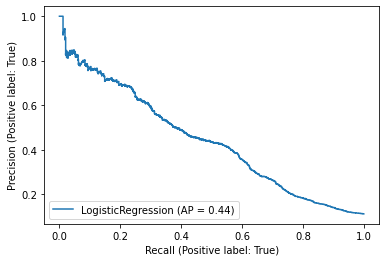

In [108]:
based = LogisticRegression(solver='liblinear').fit(xx_train, y_train)
get_pr(y_test, based.predict(xx_test))
PrecisionRecallDisplay.from_estimator(based, xx_test, y_test)

### Встроенные методы

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отбора признаков с помощью линейной модели. Как известно, веса линейной модели можно интерпретировать как вклад каждого признака в предсказание таргета, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным (embedded methods), так как он заложен в особенности модели.

__Задание 8 (0.5 балла).__ Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модель заново и оцените её качество. Замерьте скорость такого отбора признаков.

Изменилось ли качество? Как?



  Drop N columns with least abs coefficients.

  X : not empty pd.DataFrame instance  
  y : an array of targets  
  N : number of columns  to drop  
    
  Return:
  Other columns of X

In [109]:
def drop_lower_than_n(X, y, N=0):

    from sklearn.linear_model import LinearRegression
    model = LinearRegression().fit(X, y)
  
    return pd.DataFrame({'Coefficents': abs(model.coef_), 'Columns': list(xx_train.columns)}).sort_values(by='Coefficents', ascending=False)['Columns'][:40].tolist()

In [110]:
cols = drop_lower_than_n(xx_train, y_train, N=40)
XX_train, XX_test = xx_train[cols], xx_test[cols]
XX_test.head()

,cons.price.idx,month_mar,emp.var.rate,month_jun,month_may,month_nov,month_aug,poutcome_success,month_dec,euribor3m,poutcome_failure,month_apr,month_oct,contact_cellular,contact_telephone,job_student,job_retired,education_illiterate,day_of_week_mon,default_yes,marital_unknown,default_no,previous,job_blue-collar,job_unemployed,poutcome_nonexistent,day_of_week_wed,month_jul,job_housemaid,job_unknown,education_basic.4y,job_management,education_professional.course,job_services,day_of_week_thu,marital_married,education_basic.9y,marital_divorced,education_high.school,cons.conf.idx
0,93.444,0.0,1.4,0.0,0.0,0.0,1.0,0.0,0.0,4.965,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-36.1
1,93.918,0.0,1.4,0.0,0.0,0.0,0.0,0.0,0.0,4.962,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,-42.7
2,93.994,0.0,1.1,0.0,1.0,0.0,0.0,0.0,0.0,4.858,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-36.4
3,93.994,0.0,1.1,0.0,1.0,0.0,0.0,0.0,0.0,4.860,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-36.4
4,93.200,0.0,-0.1,0.0,0.0,1.0,0.0,0.0,0.0,4.021,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-42.0


Precision score: 0.6842105263157895 
Recall score: 0.22413793103448276


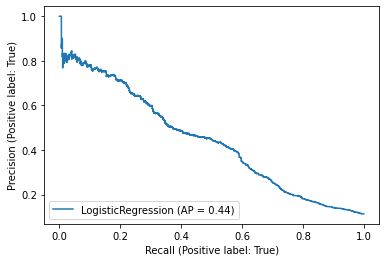

In [111]:
based = LogisticRegression(solver='liblinear').fit(XX_train, y_train)
get_pr(y_test, based.predict(XX_test))
PrecisionRecallDisplay.from_estimator(based, XX_test, y_test) # стало немного хуже

А теперь давайте подумаем, что мы не учли. Мы предположили, что признаки вносят вклад равномерно, но не учли их масштаба. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки каким-то известным вам способом, а только потом будем удалять признаки. 

Кстати, в таком случае надо пересчитать качество на всех признаках (это тоже сделайте ниже).

Что получилось?

In [112]:
# есть два варианта трансформировать данные: все или только числовые, первый вариант абсурден

typetransform = ColumnTransformer(transformers = [('standartize', StandardScaler(), numeric_features)], remainder = 'passthrough').fit(xx_train)

columns = split_prefixes(typetransform) # Н
xx_train_scaled = pd.DataFrame(data=typetransform.transform(xx_train), columns=columns)
xx_test_scaled = pd.DataFrame(data=typetransform.transform(xx_test), columns=columns)
print(xx_test_scaled.shape)
xx_test_scaled.head(3)

(8238, 62)


,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,-0.768970,0.160888,0.193904,-0.349055,0.837041,-0.231436,0.951771,0.772563,0.841655,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-1.057053,-0.568411,0.193904,-0.349055,0.837041,0.586681,-0.476424,0.770833,0.841655,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,-0.672942,-0.568411,0.193904,-0.349055,0.645914,0.717855,0.886853,0.710827,0.329181,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


Precision score: 0.6446540880503144 
Recall score: 0.2209051724137931


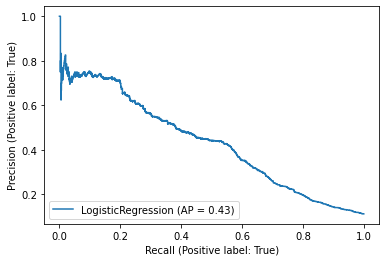

In [113]:
cols = drop_lower_than_n(xx_train_scaled, y_train, N=40)
xx_train_scaled_d, xx_test_scaled_d = xx_train_scaled[cols], xx_test_scaled[cols]

scaled_drop = LogisticRegression(solver='liblinear', max_iter=1000).fit(xx_train_scaled_d, y_train)
get_pr(y_test, scaled_drop.predict(xx_test_scaled_d))
PrecisionRecallDisplay.from_estimator(scaled_drop, xx_test_scaled_d, y_test) # cтало незначительно лучше

### Методы фильтрации


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods. 

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

__Задание 9 (0.5 балла).__ Оставьте 40 признаков с наибольшим значением $t$ и замерьте качество. Не забудьте замерить скорость отбора признаков в этом случае.



In [114]:
  '''
  Returns
  -----------
  dictionary of column with corresponding t-stat,
  if all values in column are zeros, its t-stat is nan
  '''
def calc_t_stat(X, y):
    X_temp = X.copy()
    X_temp['target'] = y.array
  
    t_dict = {}

    for column in X.columns:

        if X_temp[column].dtype != 'object' and column != 'target':
            mean_y0, mean_y1 = X_temp.groupby('target')[column].mean()
            var_y0, var_y1 = X_temp.groupby('target')[column].var()
            count_y0, count_y1 = X_temp.groupby('target')[column].count()

            t_stat = (abs(mean_y1 - mean_y0)) / np.sqrt((count_y1*var_y1 + count_y0*var_y0) / (count_y0 + count_y1))

            t_dict[column] = t_stat

    return t_dict

In [115]:
%%time 
tt = calc_t_stat(xx_train, y_train) # замерим скорость отбора признаков

Wall time: 195 ms


In [116]:
keys, values = zip(*sorted(tt.items(), reverse=True))

Precision score: 0.6853932584269663 
Recall score: 0.19719827586206898


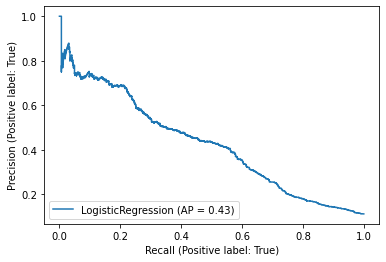

In [117]:
t_cols = list(keys[:40])

xx_train_t = xx_train[t_cols]
xx_test_t = xx_test[t_cols]


t_reg = LogisticRegression().fit(xx_train_t, y_train)
get_pr(y_test, t_reg.predict(xx_test_t))
PrecisionRecallDisplay.from_estimator(t_reg, xx_test_t, y_test)

In [118]:
xx_test_t

,previous,poutcome_success,poutcome_nonexistent,poutcome_failure,pdays,nr.employed,month_sep,month_oct,month_nov,month_may,month_mar,month_jun,month_jul,month_dec,month_aug,month_apr,marital_unknown,marital_single,marital_married,marital_divorced,loan_yes,loan_unknown,loan_no,job_unknown,job_unemployed,job_technician,job_student,job_services,job_self-employed,job_retired,job_management,job_housemaid,job_entrepreneur,job_blue-collar,job_admin.,housing_yes,housing_unknown,housing_no,euribor3m,emp.var.rate
0,0.0,0.0,1.0,0.0,999.0,5228.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.965,1.4
1,0.0,0.0,1.0,0.0,999.0,5228.1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.962,1.4
2,0.0,0.0,1.0,0.0,999.0,5191.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,4.858,1.1
3,0.0,0.0,1.0,0.0,999.0,5191.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.860,1.1
4,0.0,0.0,1.0,0.0,999.0,5195.8,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,4.021,-0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8233,0.0,0.0,1.0,0.0,999.0,5191.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,4.856,1.1
8234,0.0,0.0,1.0,0.0,999.0,5099.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.405,-1.8
8235,0.0,0.0,1.0,0.0,999.0,5228.1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.963,1.4
8236,0.0,0.0,1.0,0.0,999.0,5191.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,4.856,1.1


### Методы-обёртки

__Бонус (1 балл).__ 

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества).

Заметим, что во время отбора признаков нельзя подсматривать в тестовую выборку (так же как и при настройке гиперпараметров). Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [119]:
try:
    X_train_ob, X_val_ob, y_train_ob, y_val_ob = train_test_split(xx_train, y_train, train_size=0.75, random_state=42,stratify=y_train)
    X_test_ob=xx_test
except:
    pass

In [120]:
from sklearn.metrics import f1_score
t_reg = LogisticRegression(solver='liblinear').fit(X_train_ob, y_train_ob)
y_pred= t_reg.predict(X_val_ob)
score=f1_score(y_val_ob,y_pred, average='macro')
score

0.6295460117842768

In [121]:
%%time
while len(X_train_ob.columns)!=40:
    for i in X_train_ob.columns:
        col1=X_train_ob[i]
        col2=X_val_ob[i]
        col3=X_test_ob[i]
        X_train_ob=X_train_ob.drop(i,axis=1)
        X_val_ob=X_val_ob.drop(i,axis=1)
        X_test_ob=X_test_ob.drop(i,axis=1)
        t_reg = LogisticRegression(solver='liblinear').fit(X_train_ob, y_train_ob)
        y_pred= t_reg.predict(X_val_ob)
        score1=f1_score(y_val_ob,y_pred, average='macro')
        if(score1<score):
            X_train_ob[i] = col1
            X_val_ob[i] = col2
            X_test_ob[i] = col3
        else:
            score=score1
        if len(X_train_ob.columns)==40:
            break
       
        

Wall time: 12.3 s


In [122]:
len(X_train_ob.columns)

40

Precision score: 0.6713483146067416 
Recall score: 0.25754310344827586


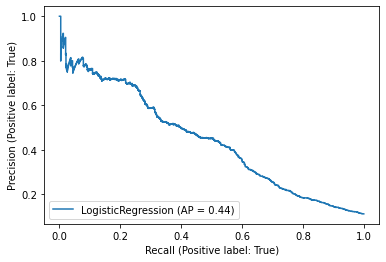

In [123]:
t_reg = LogisticRegression(solver='liblinear').fit(X_train_ob, y_train_ob)
get_pr(y_test, t_reg.predict(X_test_ob))
PrecisionRecallDisplay.from_estimator(t_reg, X_test_ob, y_test)

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

Порог однозначно найдется, если мы не отследим повторение столбцов. К тому же, если будет большое количество наших признаков, модель будет склонна к переобучению

**Стоит отметить что призанки были отсортированы по полезности**

In [124]:
t_cols = list(keys)

X_train = xx_train[t_cols]
X_test_rev = xx_test[t_cols]

In [125]:
try:
    X_train_rev, X_val_rev, y_train_rev, y_val_rev= train_test_split(X_train, y_train, train_size=0.75, random_state=42,stratify=y_train)
except:
    pass

In [126]:
t_cols = list(keys[:1])

X_train_e = X_train_rev[t_cols]
X_test_e = X_test_rev[t_cols]
X_val_e=X_val_rev[t_cols]

y_val_e=y_val_rev
y_train_e=y_train_rev

In [127]:
from sklearn.metrics import f1_score
t_reg = LogisticRegression(solver='liblinear').fit(X_train_e, y_train_e)
y_pred= t_reg.predict(X_val_e)
score=f1_score(y_val_e,y_pred, average='macro')
score

0.5039083901683323

In [136]:
%%time
while len(X_train_e.columns)!=40:
    for i in keys[1:]:
        X_train_e[i]=X_train_rev[i].copy()
        X_val_e[i]=X_val_rev[i].copy()
        X_test_e[i]=X_test_rev[i].copy()
        t_reg = LogisticRegression(solver='liblinear').fit(X_train_e, y_train_e)
        y_pred= t_reg.predict(X_val_e)
        score1=f1_score(y_val_e,y_pred, average='macro')
        if(score1<score):
            X_train_e=X_train_e.drop(i,axis=1)
            X_val_e=X_val_e.drop(i,axis=1)
            X_test_e=X_test_e.drop(i,axis=1)
        else:
            score=score1
        if len(X_train_e.columns)==40:
            break
       
  

Wall time: 0 ns


In [133]:
from sklearn.metrics import f1_score
t_reg = LogisticRegression(solver='liblinear').fit(X_train_e, y_train_e)
y_pred= t_reg.predict(X_val_e)
score=f1_score(y_val_e,y_pred, average='macro')
score

0.6355096968531997

Precision score: 0.6355140186915887 
Recall score: 0.21982758620689655


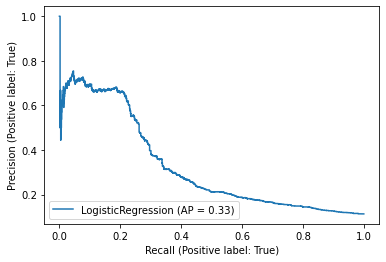

In [134]:
t_reg = LogisticRegression(solver='liblinear').fit(X_train_e, y_train_e)
get_pr(y_test, t_reg.predict(X_test_e))
PrecisionRecallDisplay.from_estimator(t_reg, X_test_e, y_test)

**Вопрос для всех**: Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** Сразу можно отметить достаточную долгую работу методов-оберток, тк нам приходится несколько раз обучать наш классификатор на разных данных. Что касается результатов, то методы показывают примерно одинаковое качество. Можно отметить, что встроенные методы показывают точность чуть большую, чем остальные методы

## Часть 4. Оценка экономического эффекта модели (2 балла)

В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе. А именно: мы будем считать некоторые метрики и с их помощью попытаемся настроить модель на максимизацию _прибыли_. Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. 

__Задание 10 (1 балл).__ Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов.


=== Краткий курс экономики от ФКН 👒===

   - Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.

=== Конец краткого курса экономики от ФКН 👒 ===

Загрузите данные о телемаркетинге из предыдущего блока заданий. В этой части не нужно делить выборку - мы будем использовать кросс-валидацию. Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки. Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков, гиперпараметры оставьте со значениями по умолчанию) и сделайте предсказания для соответствующих тестовых выборок. Допустим, всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Сколько денег вы в среднем заработаете? Также вычислите стандартное отклонение.

Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [249]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

y = df['y']
X = df.drop(columns=['duration', 'y'])
y = y.replace({'no': 0, 'yes': 1})

In [250]:
X=X.select_dtypes(exclude=['object']).join(pd.get_dummies(X.select_dtypes(include=['object'])))

In [251]:
from sklearn.model_selection import KFold, cross_validate,cross_val_predict

kf = KFold(n_splits=5, shuffle=True, random_state=500)

model = LogisticRegression(solver='liblinear')
y_pred = cross_val_predict(model, X, y, cv=kf)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [252]:
df = pd.DataFrame(y_pred)
df[0].value_counts()

0    39746
1     1442
Name: 0, dtype: int64

Посчитаем выручку:

In [253]:
df[0].value_counts()[1]*9
#Такое количество долларов получим

12978

In [254]:
df[0].std()
#Стандартное отклонение

0.18380778958257785

Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [255]:
import random
 
number = random.randrange(19)  # значение от 0 до 20
df[0].value_counts()[1]*number

20188

In [256]:
df[0].std()

0.18380778958257785

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, также укажите стандартные отклонения (вам поможет `plt.errorbar`).

In [257]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

y = df['y']
X = df.drop(columns=['duration', 'y'])
y = y.replace({'no': 0, 'yes': 1})
X=X.select_dtypes(exclude=['object']).join(pd.get_dummies(X.select_dtypes(include=['object'])))

In [280]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV


param_grid = {'Cs': [10,20]} #Подобрать адекватный диапазон параметров 
clf = LogisticRegressionCV(solver='liblinear',cv=5,random_state=500)
gs = GridSearchCV(clf, param_grid)
gs.fit(X,y)
sorted(gs.cv_results_['param_Cs'])

[10, 20]

__Задание 11 (1 балл).__ Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для этого бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ Так как для нас является целью посчитать примерное количество прибыли, то важнее для нас будет точность(precision)



Вспомним, что на самом деле логистическая регрессия предсказывает вероятности положительного класса для объекта. Возможно, путем настройки порога бинаризации этих вероятностей мы сможем получить какой-то выигрыш? Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [288]:
submission_binary=pd.DataFrame(clf.predict_proba(X))
for i in range(0,1,0.01):
    y_pred=submission_binary.applymap(lambda x: 1 if x>i else 0)
    print('Our testing accuracy for  is ')

NotFittedError: This LogisticRegressionCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Как вы, вероятно, уже поняли, ваша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом - выберите только те пороги, на которых достигается необходимый recall, затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат и посчитайте площадь под отсеченной кривой. 

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

__Бонус (1 балл):__ чтобы получить 1 балл, вставьте что угодно в ячейку ниже. Даже можно не ходить в музей.

(Бонус может получить только тот, кто решил хотя бы одно задание).

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_jobs=-1, random_state = 7).fit(XX_train, y_train)
get_pr(y_test, forest.predict(XX_test))
PrecisionRecallDisplay.from_estimator(forest, XX_test, y_test)